In [159]:
# import os; os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [160]:
import tensorflow as tf; tf.test.is_gpu_available()

2024-04-03 12:38:09.836341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 442 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5


True

In [161]:
tf.__version__

'2.8.0'

In [162]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU devices found. TensorFlow will run on CPU.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [163]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3144996735541154386
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 463929344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2822965935308534103
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2024-04-03 12:38:09.863793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 442 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5


In [164]:
# from google.colab import drive
# drive.mount('/content/drive')

In [165]:
## importing required packages
import numpy as np
from os import listdir
import tensorflow as tf
import keras
from  keras import layers
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

import matplotlib.pyplot as plt

In [166]:
## CONFIGURATION 
EPOCHS = 10
BUFFER_SIZE = 5000
BATCH_SIZE = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

In [167]:
# image_dir = "/content/drive/My Drive/3d printer/codes/datasets/cropped-datasets/"
# masks_dir = "/content/drive/My Drive/3d printer/codes/datasets/ground-truth/"

image_dir = "./All_images/"
masks_dir = "./All_masks/"

In [168]:
# import glob
# img_files = glob.glob(image_dir + '/**/*.jpg', recursive=True)
# mask_files = glob.glob(masks_dir + '/**/*.png', recursive=True)
# img_files[:10], mask_files[:10]

In [169]:
img_folders = ['abyek_images', 'imgs_deliniation', 'original_bound_detection']
mask_folders = ['abyek_masks', 'masks_deliniation', 'img_bound_detection']

images_path, masks_path = [], []

for fol, mfol in zip(img_folders, mask_folders):
    images_list = listdir(image_dir + fol)
    masks_list = listdir(masks_dir + mfol)

    img_list = [i.split('.jpg')[0] for i in images_list]
    msk_list = [i.split('.png')[0] for i in masks_list]

    commons = list(set(img_list) & set(msk_list))

    ip =  [image_dir + fol + "/" + i + ".jpg"  for i in commons]
    mp  = [masks_dir + mfol + "/" + i + ".png"  for i in commons]

    images_path.extend(ip)
    masks_path.extend(mp)

In [170]:
images_path[:10], masks_path[:10] 

(['./All_images/abyek_images/1135.jpg',
  './All_images/abyek_images/724.jpg',
  './All_images/abyek_images/1254.jpg',
  './All_images/abyek_images/1374.jpg',
  './All_images/abyek_images/1105.jpg',
  './All_images/abyek_images/723.jpg',
  './All_images/abyek_images/1050.jpg',
  './All_images/abyek_images/992.jpg',
  './All_images/abyek_images/251.jpg',
  './All_images/abyek_images/821.jpg'],
 ['./All_masks/abyek_masks/1135.png',
  './All_masks/abyek_masks/724.png',
  './All_masks/abyek_masks/1254.png',
  './All_masks/abyek_masks/1374.png',
  './All_masks/abyek_masks/1105.png',
  './All_masks/abyek_masks/723.png',
  './All_masks/abyek_masks/1050.png',
  './All_masks/abyek_masks/992.png',
  './All_masks/abyek_masks/251.png',
  './All_masks/abyek_masks/821.png'])

In [171]:
def load_images(image_path, mask_path, img_size = (IMG_HEIGHT, IMG_WIDTH)):
  # load our images from the image and mask path
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)
  mask = mask / 255

  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask, img_size, method = 'nearest')
  
  return img, mask

In [172]:
dataset = tf.data.Dataset.from_tensor_slices((images_path, masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

In [173]:
seed = 123
# divide our dataset into training and test set
val_dataset = (dataset
               .take(300)
               .prefetch(buffer_size=tf.data.AUTOTUNE) 
               )
train_dataset = (dataset
                .skip(300)
                .map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed)))
                .map(lambda image, label: (tf.image.random_flip_left_right(image, seed=seed), tf.image.random_flip_left_right(label, seed=seed)))
                .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=0.8), label))               
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                .repeat(10)
                ) 
# train_dataset = train_dataset.map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed))).repeat(1)

In [174]:
train_dataset.cardinality().numpy()

38460

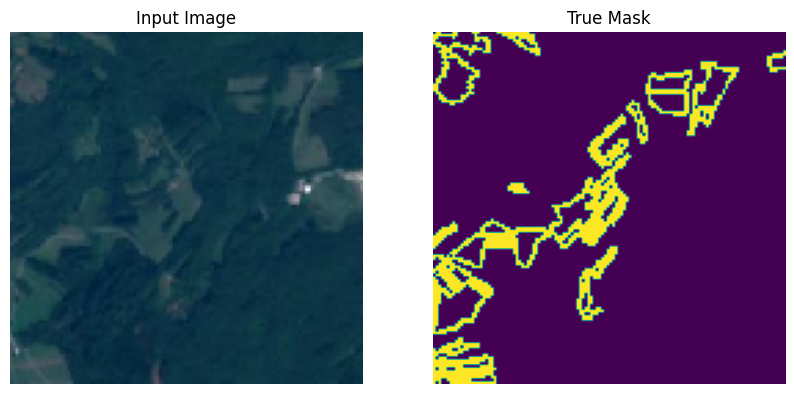

In [175]:
# plot images
def display(display_list):
  plt.figure(figsize=(10,10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image[0],mask[0]
  display([sample_image,sample_mask])
  

## Unet Model


In [176]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [177]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
   l1 = 4
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, l1*2)
   # 2 - downsample
   f2, p2 = downsample_block(p1, l1*4)
   # 3 - downsample
   f3, p3 = downsample_block(p2, l1*8)
   # 4 - downsample
   f4, p4 = downsample_block(p3,l1*16)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, l1*32)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, l1*16)
   # 7 - upsample
   u7 = upsample_block(u6, f3, l1*8)
   # 8 - upsample
   u8 = upsample_block(u7, f2, l1*4)
   # 9 - upsample
   u9 = upsample_block(u8, f1, l1*2)

   # outputs
   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [178]:
model = build_unet_model()

In [179]:
from tensorflow.keras.optimizers import Adam

model.compile(
     optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=['accuracy'],
  )

In [180]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 8)  224         ['input_4[0][0]']                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 8)  584         ['conv2d_57[0][0]']              
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 64, 64, 8)   0           ['conv2d_58[0][0]']          

In [181]:
callbacks = [
    # ReduceLROnPlateau(patience=3, verbose=1),
    # EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('unet-model.h5', verbose=0, save_best_only=True,save_weights_only=False)
    ]

In [182]:
  # fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      # validation_steps = 8,
      # batch_size=BATCH_SIZE,
      callbacks = callbacks, 
    )

Epoch 1/10


38460/38460 [==============================] - 343s 9ms/step - loss: 0.3298 - accuracy: 0.8639 - val_loss: 0.3016 - val_accuracy: 0.8715
Epoch 2/10
38460/38460 [==============================] - 340s 9ms/step - loss: 0.3034 - accuracy: 0.8697 - val_loss: 0.3154 - val_accuracy: 0.8647
Epoch 3/10
38460/38460 [==============================] - 342s 9ms/step - loss: 0.2983 - accuracy: 0.8710 - val_loss: 0.3250 - val_accuracy: 0.8595
Epoch 4/10
38460/38460 [==============================] - 341s 9ms/step - loss: 0.2951 - accuracy: 0.8719 - val_loss: 0.2935 - val_accuracy: 0.8734
Epoch 5/10
38460/38460 [==============================] - 355s 9ms/step - loss: 0.2927 - accuracy: 0.8725 - val_loss: 0.3000 - val_accuracy: 0.8702
Epoch 6/10
38460/38460 [==============================] - 357s 9ms/step - loss: 0.2915 - accuracy: 0.8727 - val_loss: 0.3019 - val_accuracy: 0.8689
Epoch 7/10
38460/38460 [==============================] - 346s 9ms/step - loss: 0.2898 - accuracy: 0.8732 - val_loss: 0.293

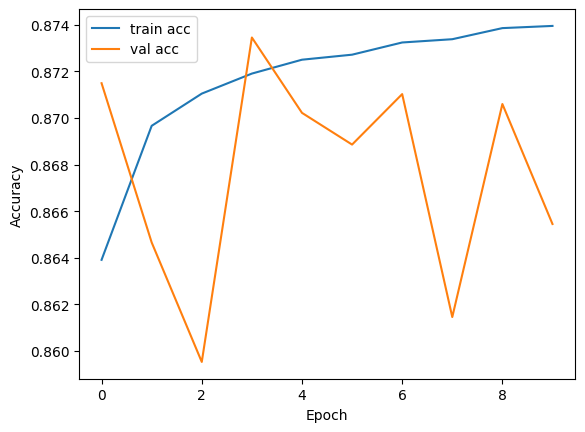

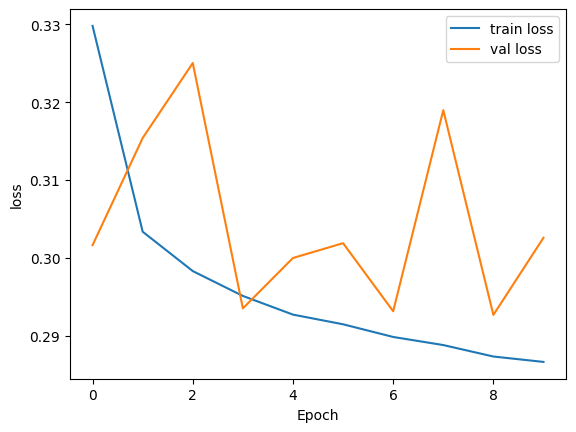

In [183]:
plt.plot(history.history["accuracy"], label='train acc')
plt.plot(history.history["val_accuracy"], label='val acc')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='val loss')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [184]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    pred = pred_mask[0]
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    # pred_mask = pred_mask[..., tf.newaxis]
    return pred

In [185]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image, verbose=0)
            # print(pred_mask[0][pred_mask[0]>0.5])
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

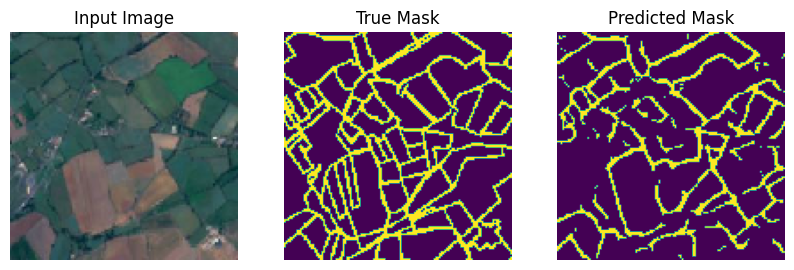

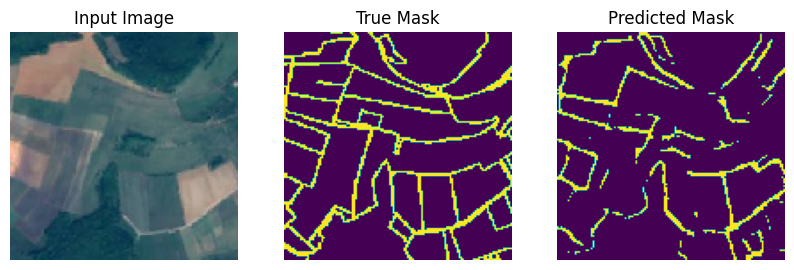

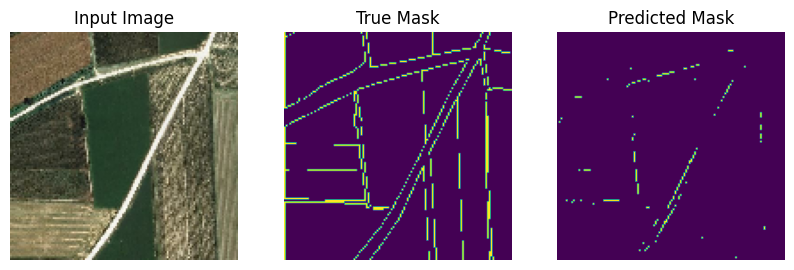

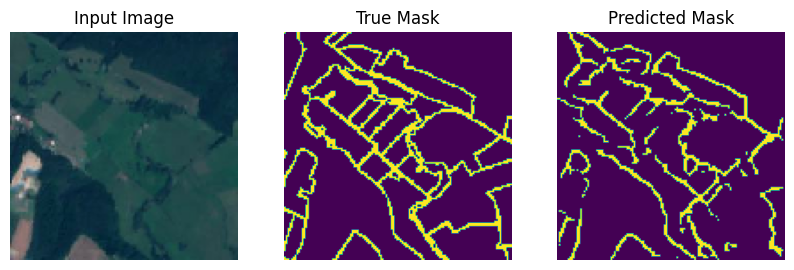

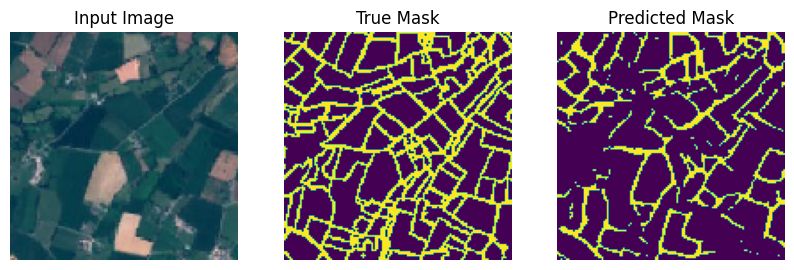

In [187]:
## displaying our result
show_predictions(val_dataset,num=5)